# Import Libraries

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
from multiprocessing import Process, Queue

import warnings
warnings.filterwarnings("ignore")

# Data Exploration

In [2]:
train_male = len(os.listdir("/kaggle/input/gender-classification-dataset/Training/male"))
train_female = len(os.listdir("/kaggle/input/gender-classification-dataset/Training/female"))
valid_male = len(os.listdir("/kaggle/input/gender-classification-dataset/Validation/male"))
valid_female = len(os.listdir("/kaggle/input/gender-classification-dataset/Validation/female"))
print(f"There are {train_male} male and {train_female} female in the training set")
print(f"There are {valid_male} male and {valid_female} female in the validation set")

There are 23766 male and 23243 female in the training set
There are 5808 male and 5841 female in the validation set


In [3]:
shapes = np.array([cv2.imread(path, -1).shape for path in np.random.choice(glob.glob("/kaggle/input/gender-classification-dataset/**/**/*"), 1000, replace=False)])
if not np.all(shapes==shapes[0]):
    print("Not all images have the same shape")
else:
    print(f"Almost all images are of shape {shapes[0]}")

Not all images have the same shape


In [4]:
np.min(shapes, axis=0), np.max(shapes, axis=0), np.mean(shapes, axis=0), np.median(shapes, axis=0)

(array([86, 69,  3]),
 array([137, 100,   3]),
 array([107.464,  82.899,   3.   ]),
 array([108.,  83.,   3.]))

In [5]:
median_shape = np.median(shapes, axis=0).astype(int)
min_shape = np.min(shapes, axis=0).astype(int)

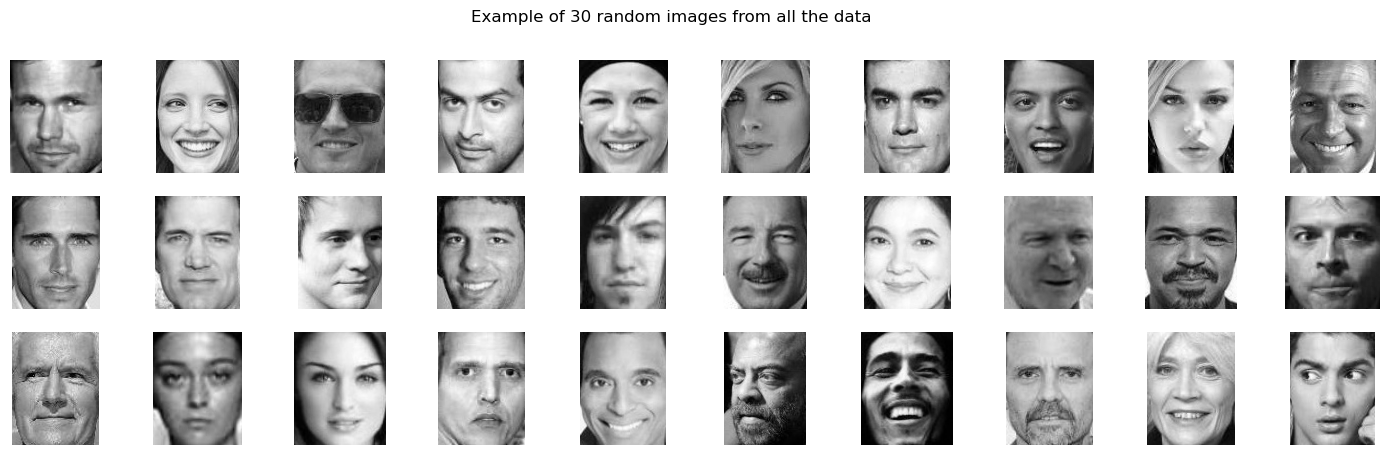

In [6]:
random_imgs = np.random.choice(glob.glob("/kaggle/input/gender-classification-dataset/**/**/*"), 30, replace=False)
plt.figure(figsize = (18, 5))
plt.suptitle(f"Example of {len(random_imgs)} random images from all the data")
for i in range(len(random_imgs)):
    plt.subplot(3,10,i+1)
    img = cv2.imread(random_imgs[i], -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')

plt.show()

# Data Loader

We will create a class to load and generate data to our model. The class will be responsible of reading, shuffling and feeding the data into the fully connected network. 

In [7]:
class DataLoader:
    def __init__(self, data_path, batch_size, shape, samples=-1):
        self._X, self._Y = self._read_data_path(data_path)
        self._batch_size = batch_size
        samples = samples if samples > 0 else self.__len__()
        self.nb_iterations = min(self.__len__()//batch_size, samples//batch_size)
        self._shape = shape
    
    def __len__(self):
        return len(self._X)
    
    def get_shape(self):
        return np.prod(self._shape)
    
    def _read_data_path(self, data_path):
        """
        This method takes the path to training or validation data,
        and return two arrays X and Y. X contains the full path to
        all images, and Y contains the corresponding labels:
        0 for male, 1 for female.
        
        data_path: str, the path to the training or validation dataset
        return:
        tuple (X, Y) of type np.array each
        """
        X = glob.glob(os.path.join(data_path, "male/*"))
        Y = [0]*len(X)
        
        X.extend(glob.glob(os.path.join(data_path, "female/*")))
        Y.extend([1]*(len(X)-len(Y)))
        
        return np.array(X), np.array(Y)
    
    def _shuffle(self, X, Y):
        idx = np.random.choice(np.arange(len(X)), len(X), replace=False)
        return X[idx], Y[idx]

    def _read_data(self, X):
        imgs = []
        def read_single_image(img_path):
            """
            This method takes an image path and retrun the image.
            The image should be converted into gray scale, resized into self._shape,
            normalized between 0 and 1, and vectorized.
            """
            img = cv2.cvtColor(cv2.imread(img_path, -1), cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, self._shape)
            img = img/255
            return img.flatten()
        
        for img_path in X:
            imgs.append(read_single_image(img_path))
        
        return np.array(imgs)
    
    def generator(self):
        X, Y = self._shuffle(self._X, self._Y)
        X = X[:self._batch_size*self.nb_iterations]
        Y = Y[:self._batch_size*self.nb_iterations]
        
        X = X.reshape((self.nb_iterations, self._batch_size))
        Y = Y.reshape((self.nb_iterations, self._batch_size))
        for i in np.random.choice(np.arange(self.nb_iterations), self.nb_iterations, replace=False):
            subset_X = X[i]
            subset_Y = Y[i]
            
            yield self._read_data(subset_X).T, subset_Y.T

# Network

In [8]:
class Activations:
    """
    This class implements different activation functions and their corresponding derivative.
    """
    def __init__(self):
        self._mapping = {"sigmoid": self._sigmoid,
                         "relu": self._relu}
        
    def _sigmoid(self, x):
        val =  1/(1+np.exp(-x))
        return val, val*(1-val)
    
    def _relu(self, x):
        return np.maximum(0, x), x>0
    
    def get(self, name):
        name = name.lower()
        if name not in self._mapping:
            raise ValueError(f"Unknown {name} activation")
        return self._mapping[name]
    
class FullyConnectedNetwork:
    """
    This class implements a fully connected network. It takes as arguments the input size,
    a list of hidden units and the keep rate for dropout.
    This class inplements model initialization, forward propagation, loss function and metrics,
    and backward propagation.
    N.B.: this class doesn't update the learnable parameters.
    """
    def __init__(self, input_size, hidden_units:list, keep_rate=1):
        """
        We add a layer with a single unit to the list of hidden units representing the output layer. 
        """
        self._hidden_units = hidden_units + [1]
        self._hidden_layers = len(self._hidden_units)
        self._keep_rate = keep_rate
        self._activ_func = Activations()
        self._create_variables(input_size)
        self.is_training = True
        
    def summary(self):
        """
        Print a summary of the network layers and the total number of parameters.
        """
        info_list = []
        total_params = 0
        for i in range(self._hidden_layers):
            params = np.prod(self.weights[i].shape)+np.prod(self.biases[i].shape)
            if i == self._hidden_layers - 1:
                info_list.append([f"Output layer", self.weights[i].shape, params])
            else:
                info_list.append([f"Layer {i+1}", self.weights[i].shape, params])
            total_params +=params
        info_list.append(["Total", "-", total_params])
        display.display(pd.DataFrame(info_list, columns=["Layer", "Weight shape", "Number of params"]))
    
    def _create_variables(self, input_size):
        """
        Create a list of weights and biases and initialize their value.
        The weights are initialized using _initialize_weights method.
        Biases are initialized to zeros.
        """
        self.weights = []
        self.biases = []
        shape = input_size
        for i in range(self._hidden_layers):
            w = self._initialize_weights((self._hidden_units[i], shape))
            b = np.zeros((self._hidden_units[i], 1), dtype=np.float32)
            
            self.weights.append(w)
            self.biases.append(b)
            shape = self._hidden_units[i]

    def _initialize_weights(self, weight_shape):
        """
        This method initializes the weights following He normal stratey.
        weight_shape is the shape of the weight matrix.
        """
        return np.random.normal(0, np.sqrt(1/weight_shape[0]), size=weight_shape)
    
    def _drop(self, y):
        """
        This method keeps randomly self.keep_rate units from y and correct for dropout by scaling.
        y: 2D array of type float
        """
        if self._keep_rate == 1:
            return y
        random_vector = np.random.binomial(n=1, p=self._keep_rate, size=y.shape)
        return (y*random_vector)/self._keep_rate
    
    def forward_propagation(self, X):
        """
        This class implements forward propagation. It saves the needed information to be used
        with backpropagation (the activations and their derivatives).
        X: 2D array representating a batch of inputs
        """
        self._activation = [X]
        self._activation_grad = [1]
        y = X
        for i in range(self._hidden_layers):
            w = self.weights[i]
            b = self.biases[i]
            linear = w@y + b
            
            if i != self._hidden_layers - 1 and self.is_training:
                linear = self._drop(linear)
            
            if i!=self._hidden_layers-1:
                y, grad = self._activ_func.get("relu")(linear)
            else:
                y, grad = self._activ_func.get("sigmoid")(linear)
            
            self._activation.append(y)
            self._activation_grad.append(grad)

        return y
    
    def loss(self, Y, Preds):
        """
        compute binary cross entropy loss between the ground truth and the predictions
        """
        epsilon = 1e-7
        term_1 = -Y*np.log(Preds+epsilon)
        term_2 = -(1-Y)*np.log(1-Preds+epsilon)
        return term_1 + term_2
    
    def accuracy(self, Y, Preds):
        """
        compute the accuracy of each prediction w.r.t the ground truth
        """
        return Y==(Preds>0.5)
    
    def backward_propagation(self, Y, Preds):
        """
        compute the backward propagation. You should save the weights and biases gradients
        to be used by the optmizer in order to update the weights.
        """
        self.grad_w = []
        self.grad_b = []
        gradient = (Preds - Y)/(Preds*(1-Preds))
        
        for i in range(len(self.weights), 0, -1):
            gradient = self._activation_grad[i] * gradient
            grad_w = (gradient@self._activation[i-1].T)/gradient.shape[-1]
            grad_b = np.mean(gradient, axis=-1, keepdims=True)
    
            self.grad_w.append(grad_w)
            
            self.grad_b.append(grad_b)
            
            gradient = self.weights[i-1].T@gradient
        
        self.grad_w = self.grad_w[::-1]
        self.grad_b = self.grad_b[::-1]        

# Optimizer

In [9]:
class ADAM:
    """
    This class implements ADAM optimizer. It should have access to the network in order to updte its parameters.
    network: (object) an instance of FullyConnectedNetwork class.
    lr: (int), the learning rate
    nb_iterations: (int) the total number of iteration during a single epoch
    use_cosine_decay: (bool) whether to use a cosine cyclic learning rate or not
    """
    def __init__(self, network, lr, nb_iterations, use_cosine_decay=False):
        self.network = network
        self._lr = lr
        self._iteration = 0
        self._nb_iterations = nb_iterations
        self._use_cosine_decay = use_cosine_decay
        self._create_variables()

    def _create_variables(self):
        """
        This method initializes to zero the moving averages used in ADAM.
        There is a moving average for each parameter in the network.
        """
        self._weight_gradient_average = []
        self._weight_gradient_square = []
        self._bias_gradient_average = []
        self._bias_gradient_square = []
        for i in range(len(self.network.weights)):
            self._weight_gradient_average.append(np.zeros_like(self.network.weights[i]))
            self._weight_gradient_square.append(np.zeros_like(self.network.weights[i]))
            
            self._bias_gradient_average.append(np.zeros_like(self.network.biases[i]))
            self._bias_gradient_square.append(np.zeros_like(self.network.biases[i]))
        
    def _cosine_decay_restart(self, cycle=10, alpha=0.1):
        """
        This method applies a cosine cyclic learning rate for a period of `cycle` and then restart.
        The learning rate should decrease gradually from its initial value to a value multiplied by alpha.
        For example, if initial learning rate = 0.01, alpha = 0.1, the learning rate should be after a cycle 
        of 10 epochs equal 0.01*0.1=0.001. The decay should follow a cosine function.
        cycle is represented in number of epochs.
        """
        alpha = 0.1
        decay_steps = cycle*self._nb_iterations
        cosine_decay = 0.5 * (1 + np.cos(np.pi * ((self._iteration-1) % decay_steps)/decay_steps))
        decay = (1 - alpha)*cosine_decay + alpha
        return self._lr*decay
    
    def minimize(self):
        """
        Compute the moving averages of ADAM and update the network parameters.
        Don't forget to increment the iteration counter.
        """
        epsilon = 1e-7
        rho_1, rho_2 = 0.9, 0.99
        self._iteration+=1
        
        lr = self._cosine_decay_restart() if self._use_cosine_decay else self._lr

        for i in range(len(self.network.grad_w)):
            self._weight_gradient_average[i] = rho_1*self._weight_gradient_average[i] + (1-rho_1)*self.network.grad_w[i]
            self._weight_gradient_average[i] = self._weight_gradient_average[i]/(1-rho_1**self._iteration)
            
            self._bias_gradient_average[i] = rho_1*self._bias_gradient_average[i] + (1 - rho_1)*self.network.grad_b[i]
            self._bias_gradient_average[i] = self._bias_gradient_average[i]/(1-rho_1**self._iteration)
            
            self._weight_gradient_square[i] = rho_2*self._weight_gradient_square[i] + (1-rho_2)*self.network.grad_w[i]**2
            self._weight_gradient_square[i] = self._weight_gradient_square[i]/(1-rho_2**self._iteration)
            
            self._bias_gradient_square[i] = rho_2*self._bias_gradient_square[i] + (1-rho_2)*self.network.grad_b[i]**2
            self._bias_gradient_square[i] = self._bias_gradient_square[i]/(1-rho_2**self._iteration)
            
            self.network.weights[i] = self.network.weights[i] - lr*(self._weight_gradient_average[i]/(np.sqrt(self._weight_gradient_square[i])+epsilon))
            self.network.biases[i] = self.network.biases[i] - lr*(self._bias_gradient_average[i]/(np.sqrt(self._bias_gradient_square[i])+epsilon))

In [10]:
class Model:
    """
    This class uses the other objects to train the network.
    In addition, it can save and load the network + optimizer parameters.
    network: (object) an instance of FullyConnectedNetwork
    optimizer: (object) an instance of ADAM
    epochs: (int) the total number of epochs
    save_path: (str) the path to save the data
    save_every: (int) frequency of saving the model parameters, default to each every 10 epochs
    """
    def __init__(self, network, optimizer, epochs, save_path, save_every=10):
        self._network = network
        self._optimizer = optimizer
        self._epochs = epochs
        self._path = save_path
        self._save_every = save_every
        
    def _save_parameters(self, save_path, postfix):
        """
        save all the model parameters in npz file
        """
        np.savez(os.path.join(save_path, f"parameters_{postfix}.npz"),
                 weights=self._network.weights,
                 biases=self._network.biases,
                 weights_grad=self._optimizer._weight_gradient_average,
                 biases_grad=self._optimizer._bias_gradient_average,
                 weights_grad_square=self._optimizer._weight_gradient_square,
                 biases_grad_square=self._optimizer._bias_gradient_square)
    
    def load_parameters(self, load_path, postfix):
        """
        load the model parameters from a specific npz file
        """
        params = np.load(os.path.join(load_path, f"parameters_{postfix}.npz"), allow_pickle=True)
        self._network.weights = params["weights"]
        self._network.biases = params["biases"]
        self._optimizer._weight_gradient_average = params["weights_grad"]
        self._optimizer._bias_gradient_average = params["biases_grad"]
        self._optimizer._weight_gradient_square = params["weights_grad_square"]
        self._optimizer._bias_gradient_square = params["biases_grad_square"]
        
    def _train_step(self, data, history):
        """
        perform a train step over a batch of training data, and update the history dictionary
        with the corresponding values
        """
        X, Y = data
        self._network.is_training = True
        preds = self._network.forward_propagation(X)
        loss = self._network.loss(Y, preds)
        accuracy = self._network.accuracy(Y, preds)
        if np.any(np.isnan(loss)):
            print(loss)
            raise ValueError("Training diverged and thus will be halted. Increase the training set size if possible or decrease your learning rate")

        history["train_loss"].extend(list(loss))
        history["train_accuracy"].extend(list(accuracy))
        self._network.backward_propagation(Y, preds)
        
        self._optimizer.minimize()
    
    def _validation_step(self, data, history):
        """
        perform a validation step over a batch of validation data, and update the history dictionary
        with the corresponding values
        """
        X, Y = data
        self._network.is_training = False
        preds = self._network.forward_propagation(X)
        loss = self._network.loss(Y, preds)
        accuracy = self._network.accuracy(Y, preds)
        
        history["valid_loss"].extend(list(loss))
        history["valid_accuracy"].extend(list(accuracy))

    def train(self, train_generator, validation_generator, queue):
        """
        train the model on all the training data and perform validation for a giving number of epochs.
        """
        best_accuracy = 0
        progress_bar = tqdm(range(self._epochs), total=self._epochs, desc="Training: ")
        for epoch in progress_bar:
            history = {"train_loss": [],
                       "valid_loss": [],
                       "train_accuracy": [],
                       "valid_accuracy": []}
            
            for batch in train_generator.generator():
                self._train_step(batch, history)
            for batch in validation_generator.generator():
                self._validation_step(batch, history)
            
            losses_and_metrics = []
            for k, _ in history.items():
                history[k] = np.mean(history[k])
                losses_and_metrics.append(history[k])
            
            queue.put(tuple(losses_and_metrics))
            
            if (epoch+1)%self._save_every == 0:
                self._save_parameters(self._path, epoch+1)
            
            if best_accuracy < losses_and_metrics[-1]:
                best_accuracy = losses_and_metrics[-1]
                self._save_parameters(self._path, "best")
            
            progress_bar.set_postfix(history)
        queue.put(None)
        
    def predict_proba(self, X, load_path=None, postfix=None):
        if None not in [load_path, postfix]:
            self.load_parameters(load_path, postfix)

        self._network.is_training = False
        preds = self._network.forward_propagation(X)
        
        return preds
    
    def predict(self, X, load_path=None, postfix=None):
        preds = self.predict_proba(X, load_path, postfix)
        return ['male' if pred < 0.5 else "female" for pred in preds[0]]
    
    def visualize(self, queue):
        sns.set()

        train_loss = []
        valid_loss = []
        train_acc = []
        valid_acc = []
        val = queue.get()
        fig = plt.figure(figsize=(12, 6))
        plt.suptitle("Learning Curves")
        while val is not None:

            train_loss.append(val[0])
            valid_loss.append(val[1])
            train_acc.append(val[2])
            valid_acc.append(val[3])


            plt.subplot(121)
            plt.title("cross entropy")
            plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='training', c='b')
            plt.plot(np.arange(1, len(valid_loss)+1), valid_loss, label='validation', c='r')
            plt.xlim(1, self._epochs + self._epochs//10)
            plt.ylim(0, max(max(train_loss), max(valid_loss)) + 1)
            plt.xticks(np.arange(0, self._epochs + self._epochs//10, self._epochs//10))
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), loc='upper right')

            plt.subplot(122)
            plt.title("accuracy")
            plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='training', c='b')
            plt.plot(np.arange(1, len(valid_acc)+1), valid_acc, label='validation', c='r')
            plt.xlim(1, self._epochs + self._epochs//10)
            plt.ylim(0, 1.1)
            plt.xticks(np.arange(0, self._epochs + self._epochs//10, self._epochs//10))
            plt.yticks(np.arange(0, 1.1, 0.1))
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), loc='lower right')

            display.clear_output(wait=True)
            display.display(plt.gcf())

            val = queue.get()
        display.clear_output(wait=True)

In [11]:
batch_size=32
resize_shape=(70, 70)
training_path="/kaggle/input/gender-classification-dataset/Training"
validation_path="/kaggle/input/gender-classification-dataset/Validation"

training_data = DataLoader(training_path, batch_size, resize_shape, samples=-1) # you can choose a subset of the dataset for training
validation_data = DataLoader(validation_path, batch_size, resize_shape, samples=-1)

In [12]:
keep_rate=1
hidden_units=[30, 20, 10, 5, 3]
network = FullyConnectedNetwork(input_size=training_data.get_shape(), hidden_units=hidden_units, keep_rate=keep_rate)
network.summary()

,Layer,Weight shape,Number of params
0,Layer 1,"(30, 4900)",147030
1,Layer 2,"(20, 30)",620
2,Layer 3,"(10, 20)",210
3,Layer 4,"(5, 10)",55
4,Layer 5,"(3, 5)",18
5,Output layer,"(1, 3)",4
6,Total,-,147937


In [13]:
learning_rate=0.0001
optimizer = ADAM(network, learning_rate, training_data.nb_iterations)

In [14]:
epochs=100
save_path="/kaggle/working/"
model = Model(network, optimizer, epochs=epochs, save_path=save_path)

In [15]:
queue = Queue()
training_process = Process(target=model.train, args=(training_data, validation_data, queue))
training_process.daemon = True
training_process.start()

Training: 100%|██████████| 100/100 [3:31:58<00:00, 127.18s/it, train_loss=0.163, valid_loss=0.213, train_accuracy=0.941, valid_accuracy=0.923] 


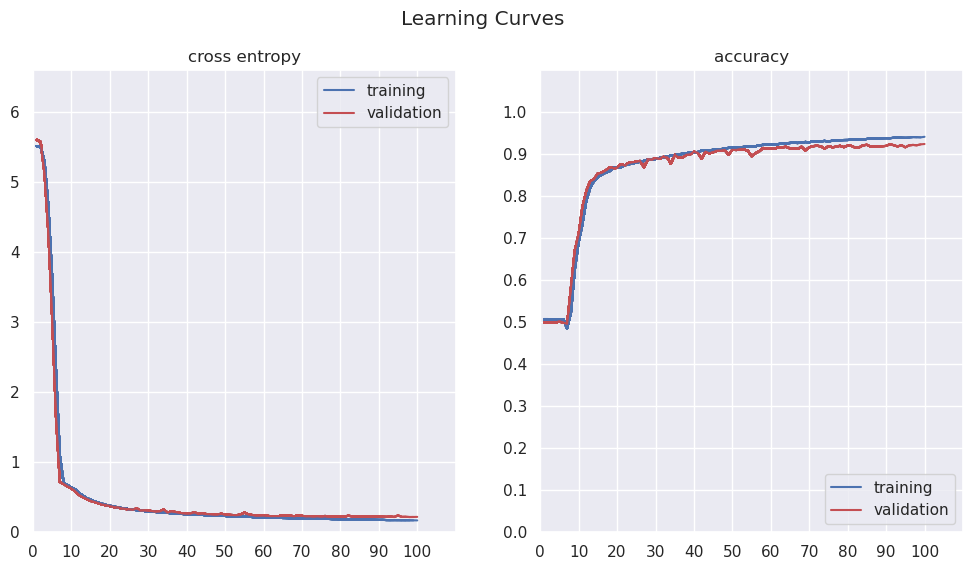

In [16]:
model.visualize(queue)

# Test the model on new images

In [17]:
fake_faces = []
for img_path in glob.glob("/kaggle/input/fake-faces/*"):
    img = cv2.cvtColor(cv2.imread(img_path, -1), cv2.COLOR_BGR2GRAY)
    fake_faces.append(img)

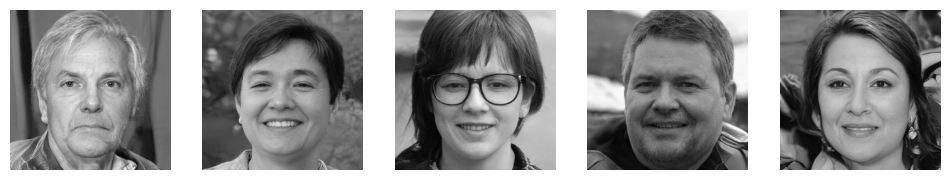

In [18]:
plt.figure(figsize=(12, 5))
for i in range(len(fake_faces)):
    plt.subplot(1, len(fake_faces), i+1)
    plt.imshow(fake_faces[i], cmap = 'gray')
    plt.axis('off')

plt.show()

In [19]:
batch_faces = []
for img in fake_faces:
    img = cv2.resize(img, resize_shape)
    img = img/255
    img = img.flatten()
    batch_faces.append(img)
    
batch_faces = np.array(batch_faces).T

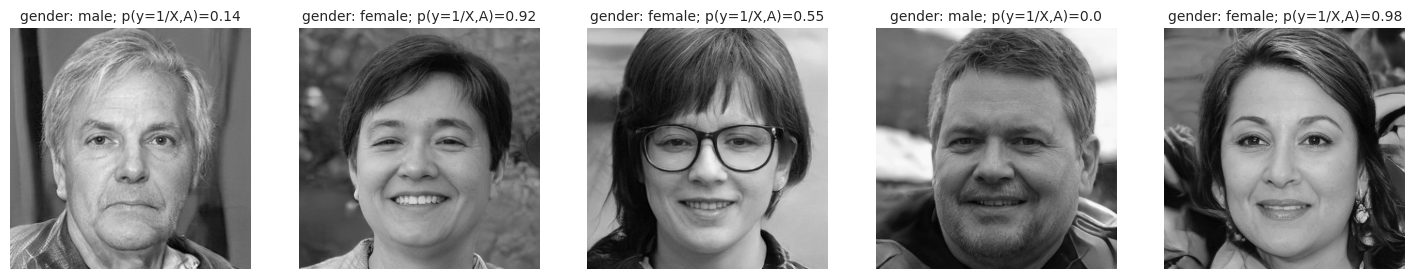

In [20]:
preds = model.predict(batch_faces, save_path, "best")
preds_proba = model.predict_proba(batch_faces, save_path, "best")
plt.figure(figsize=(18, 5))
for i in range(len(fake_faces)):
    plt.subplot(1, len(fake_faces), i+1)
    plt.title(f"gender: {preds[i]}; p(y=1/X,A)={np.round(preds_proba[0][i], 2)}", fontsize=10)
    plt.imshow(fake_faces[i], cmap = 'gray')
    plt.axis('off')

plt.show()